In [1]:
import sys
!{sys.executable} -m pip install simplegeneric mlrose

In [119]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os, sys
from datetime import datetime

import pandas as pd
import numpy as np
import mlrose

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

from matplotlib import rc
import matplotlib.pyplot as plt
import pickle

Load the training and testing data, already one hot encoded then split into X (features) and Y (outcomes).

In [4]:
# load CSVs
train = pd.read_csv("dat/nicu-train-hot.csv")
test  = pd.read_csv("dat/nicu-test-hot.csv")

# split training data
X_trn = train.iloc[:, 1:].copy()
Y_trn = train.iloc[:, 0].copy()

# split testing data
X_tst = test.iloc[:, 1:].copy()
Y_tst = test.iloc[:, 0].copy()

In [5]:
X_trn.head() # features

,dob_mm.X10,dob_mm.X11,dob_mm.X12,dob_mm.X2,dob_mm.X3,dob_mm.X4,dob_mm.X5,dob_mm.X6,dob_mm.X7,dob_mm.X8,...,ca_omph.Y,ca_gast.Y,ca_limb.Y,ca_cleft.Y,ca_clpal.Y,ca_downs.N,ca_downs.P,ca_disor.N,ca_disor.P,ca_hypo.Y
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [6]:
Y_trn.head() # outcome

0    1
1    0
2    0
3    1
4    0
Name: e_comp.Y, dtype: int64

Do 4-fold cross-validation consistent with previous assignment. Also suppresses warnings.

In [14]:
x, y = X_trn.values, Y_trn.values

seed = 1
kf = KFold(n_splits=4)
np.random.seed(seed)

# https://docs.python.org/3/library/warnings.html#warnings.catch_warnings
import warnings
warnings.simplefilter("ignore")

Supporting functions to systematically evaluate algorithms and plot the graphs.

In [15]:
def evaluate(algo_name, param_name, clf, kf):
    # Warning, this does not clear itself
    if algo_name not in acc_tr:
        acc_tr[algo_name] = {}
        acc_te[algo_name] = {}
        time_tr[algo_name] = {}
    if param_name not in acc_tr[algo_name]:
        acc_tr[algo_name][param_name] = []
        acc_te[algo_name][param_name] = []
        time_tr[algo_name][param_name] = []
    eval_time = []
    eval_tr = []
    eval_te = []
    for train_index, test_index in kf.split(x):
        x_tr, x_te = x[train_index], x[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        time_start = datetime.now()
        clf.fit(x_tr, y_tr)
        eval_time.append((datetime.now() - time_start).microseconds)
        y_train_pred = clf.predict(x_tr)
        y_te_pred = clf.predict(x_te)
        y_train_accuracy = accuracy_score(y_tr, y_train_pred)
        y_te_accuracy = accuracy_score(y_te, y_te_pred)
        eval_tr.append(y_train_accuracy)    
        eval_te.append(y_te_accuracy)
    eval_time = np.array(eval_time).mean() / 1000
    eval_tr = np.array(eval_tr).mean()
    eval_te = np.array(eval_te).mean()
    acc_tr[algo_name][param_name].append(eval_tr)
    acc_te[algo_name][param_name].append(eval_te)    
    time_tr[algo_name][param_name].append(eval_time)

In [16]:
def purge_algo(algo, test):
    if test in acc_tr[algo]:
        del acc_tr[algo][test]
    if test in acc_te[algo]:
        del acc_te[algo][test]
    if test in time_tr[algo]:
        del time_tr[algo][test]    
    return 1

Everything ready to roll, next cell sets up (or resets) all the experimental data collected for subsequent optimization data. This includes RHC, SA, and GA in order.

In [18]:
# this will reset all experimental data
acc_tr = {}
acc_te = {}
time_tr = {}

Testing randomized hill climbing (RHC).

In [19]:
algo = 'rhc'
param = 'restarts-default'
if algo in acc_tr:
    purge_algo(algo, param)

n_range = list( range(2, 12, 2) )

for n in n_range:
    print(algo, param, n)
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation='sigmoid', \
                                     algorithm='random_hill_climb', max_iters=100, \
                                     learning_rate=0.06, restarts=n, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, param, clf, kf)

rhc restarts-default 2
rhc restarts-default 4
rhc restarts-default 6
rhc restarts-default 8
rhc restarts-default 10


The RHC curve looks weird, let's slow down the learning rate.

In [22]:
algo = 'rhc'
param = 'restarts-slow'
if algo in acc_tr:
    purge_algo(algo, param)

n_range = list( range(2, 12, 2) )

for n in n_range:
    print(algo, param, n)
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation='sigmoid', \
                                     algorithm='random_hill_climb', max_iters=100, \
                                     learning_rate=0.006, restarts=n, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, param, clf, kf)

rhc restarts-slow 2
rhc restarts-slow 4
rhc restarts-slow 6
rhc restarts-slow 8
rhc restarts-slow 10


Testing simulated annealing (SA).

In [24]:
algo = "sa"
if algo in acc_tr:
    purge_algo(algo, "decay")

dec_range = [0.10, 0.30, 0.50, .70, .90]

for dec in dec_range:
    print(algo, dec)    
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation="sigmoid", \
                                     algorithm="simulated_annealing", max_iters=100, \
                                     learning_rate=0.06, \
                                     early_stopping=True, schedule=mlrose.GeomDecay(decay=dec), \
                                     max_attempts=10)
    evaluate(algo, "decay", clf, kf)

sa 0.1
sa 0.3
sa 0.5
sa 0.7
sa 0.9


Testing genetic algorithm (GA).

In [26]:
algo = 'ga'
param = 'pop'
if algo in acc_tr:
    purge_algo(algo, param)

pop_size = range(50, 300, 50)

for pop in pop_size:
    print(algo, param, pop)
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation='sigmoid', \
                                     algorithm='genetic_alg', max_iters=100, \
                                     learning_rate=0.06, \
                                     early_stopping=True, pop_size=pop, max_attempts=10)
    evaluate(algo, 'pop', clf, kf)

ga pop 50
ga pop 100
ga pop 150
ga pop 200
ga pop 250


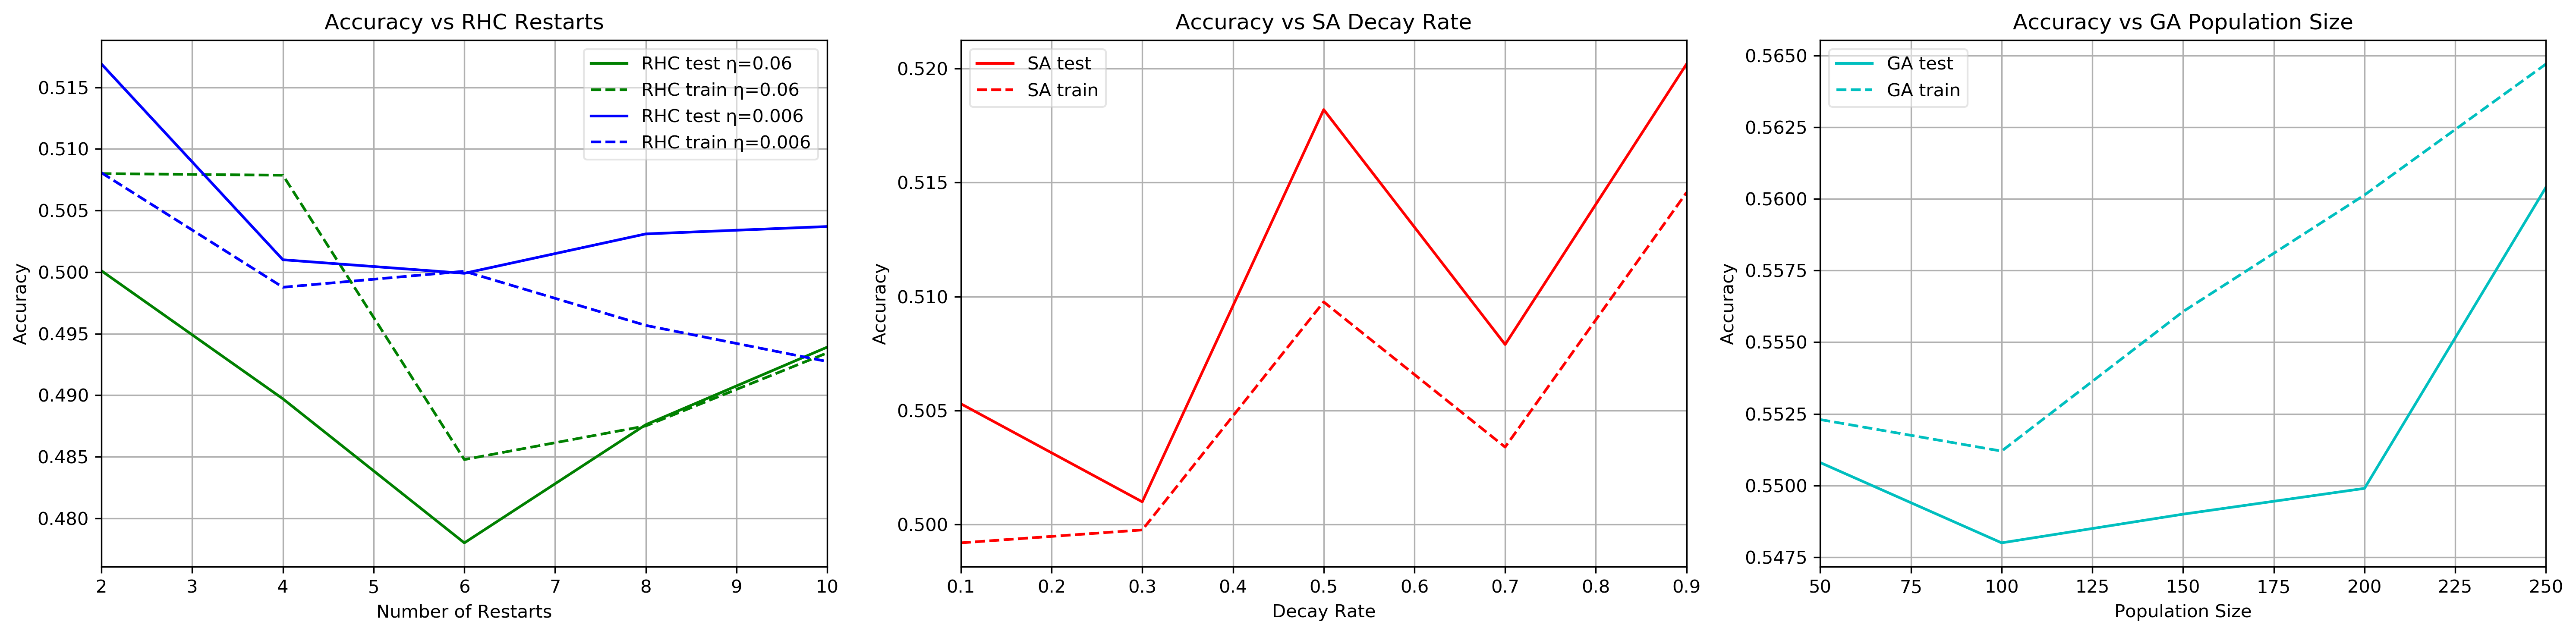

In [116]:
fig = plt.figure(figsize=(20, 5), dpi=300)

plt.subplot(1, 3, 1) # RHC
plt.plot(n_range, acc_te['rhc']['restarts-default'], label="RHC test η=0.06", linestyle='-', color='g')
plt.plot(n_range, acc_tr['rhc']['restarts-default'], label='RHC train η=0.06', linestyle='--', color='g')

plt.plot(n_range, acc_te['rhc']['restarts-slow'], label='RHC test η=0.006', linestyle='-', color='b')
plt.plot(n_range, acc_tr['rhc']['restarts-slow'], label='RHC train η=0.006', linestyle='--', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Number of Restarts")
plt.title("Accuracy vs RHC Restarts")
plt.legend(loc='upper right', fancybox=True, framealpha=0.5)
plt.xlim(left=n_range[0], right=n_range[-1])
plt.grid(True)

plt.subplot(1, 3, 2) # SA
plt.plot(dec_range, acc_te['sa']['decay'], label='SA test', linestyle='-', color='r')
plt.plot(dec_range, acc_tr['sa']['decay'], label='SA train', linestyle='--', color='r')

plt.ylabel("Accuracy")
plt.xlabel("Decay Rate")
plt.title("Accuracy vs SA Decay Rate")
plt.legend(loc='upper left', fancybox=True, framealpha=0.5)
plt.xlim(left=dec_range[0], right=dec_range[-1])
plt.grid(True)

plt.subplot(1, 3, 3) # GA
plt.plot(pop_size, acc_te['ga']['pop'], label='GA test', linestyle='-', color='c')
plt.plot(pop_size, acc_tr['ga']['pop'], label='GA train', linestyle='--', color='c')

plt.ylabel("Accuracy")
plt.xlabel("Population Size")
plt.title("Accuracy vs GA Population Size")
plt.legend(loc='upper left', fancybox=True, framealpha=0.5)
plt.xlim(left=pop_size[0], right=pop_size[-1])
plt.grid(True)

fig.tight_layout()

plt.savefig("img/randomized-parameter-tuning.png")

Compare all algorithms.

In [29]:
iteration_range = list( range(20, 120, 20) )

for i in iteration_range:
    algo = 'backprop'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation='sigmoid', \
                                     algorithm='gradient_descent', max_iters=i, \
                                     learning_rate=0.06, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter', clf, kf)
    
    algo = 'rhc'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation='sigmoid', \
                                     algorithm='random_hill_climb', max_iters=i, \
                                     learning_rate=0.06, restarts=2, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter', clf, kf)
    
    algo = 'sa'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation='sigmoid', \
                                     algorithm='simulated_annealing', max_iters=i, \
                                     learning_rate=0.06, schedule=mlrose.GeomDecay(decay=0.9), \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter', clf, kf)
    
    algo = 'ga'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=[129], activation='sigmoid', \
                                     algorithm='genetic_alg', max_iters=i, \
                                     learning_rate=0.06, pop_size=50, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter', clf, kf)

backprop 20
rhc 20
sa 20
ga 20
backprop 40
rhc 40
sa 40
ga 40
backprop 60
rhc 60
sa 60
ga 60
backprop 80
rhc 80
sa 80
ga 80
backprop 100
rhc 100
sa 100
ga 100


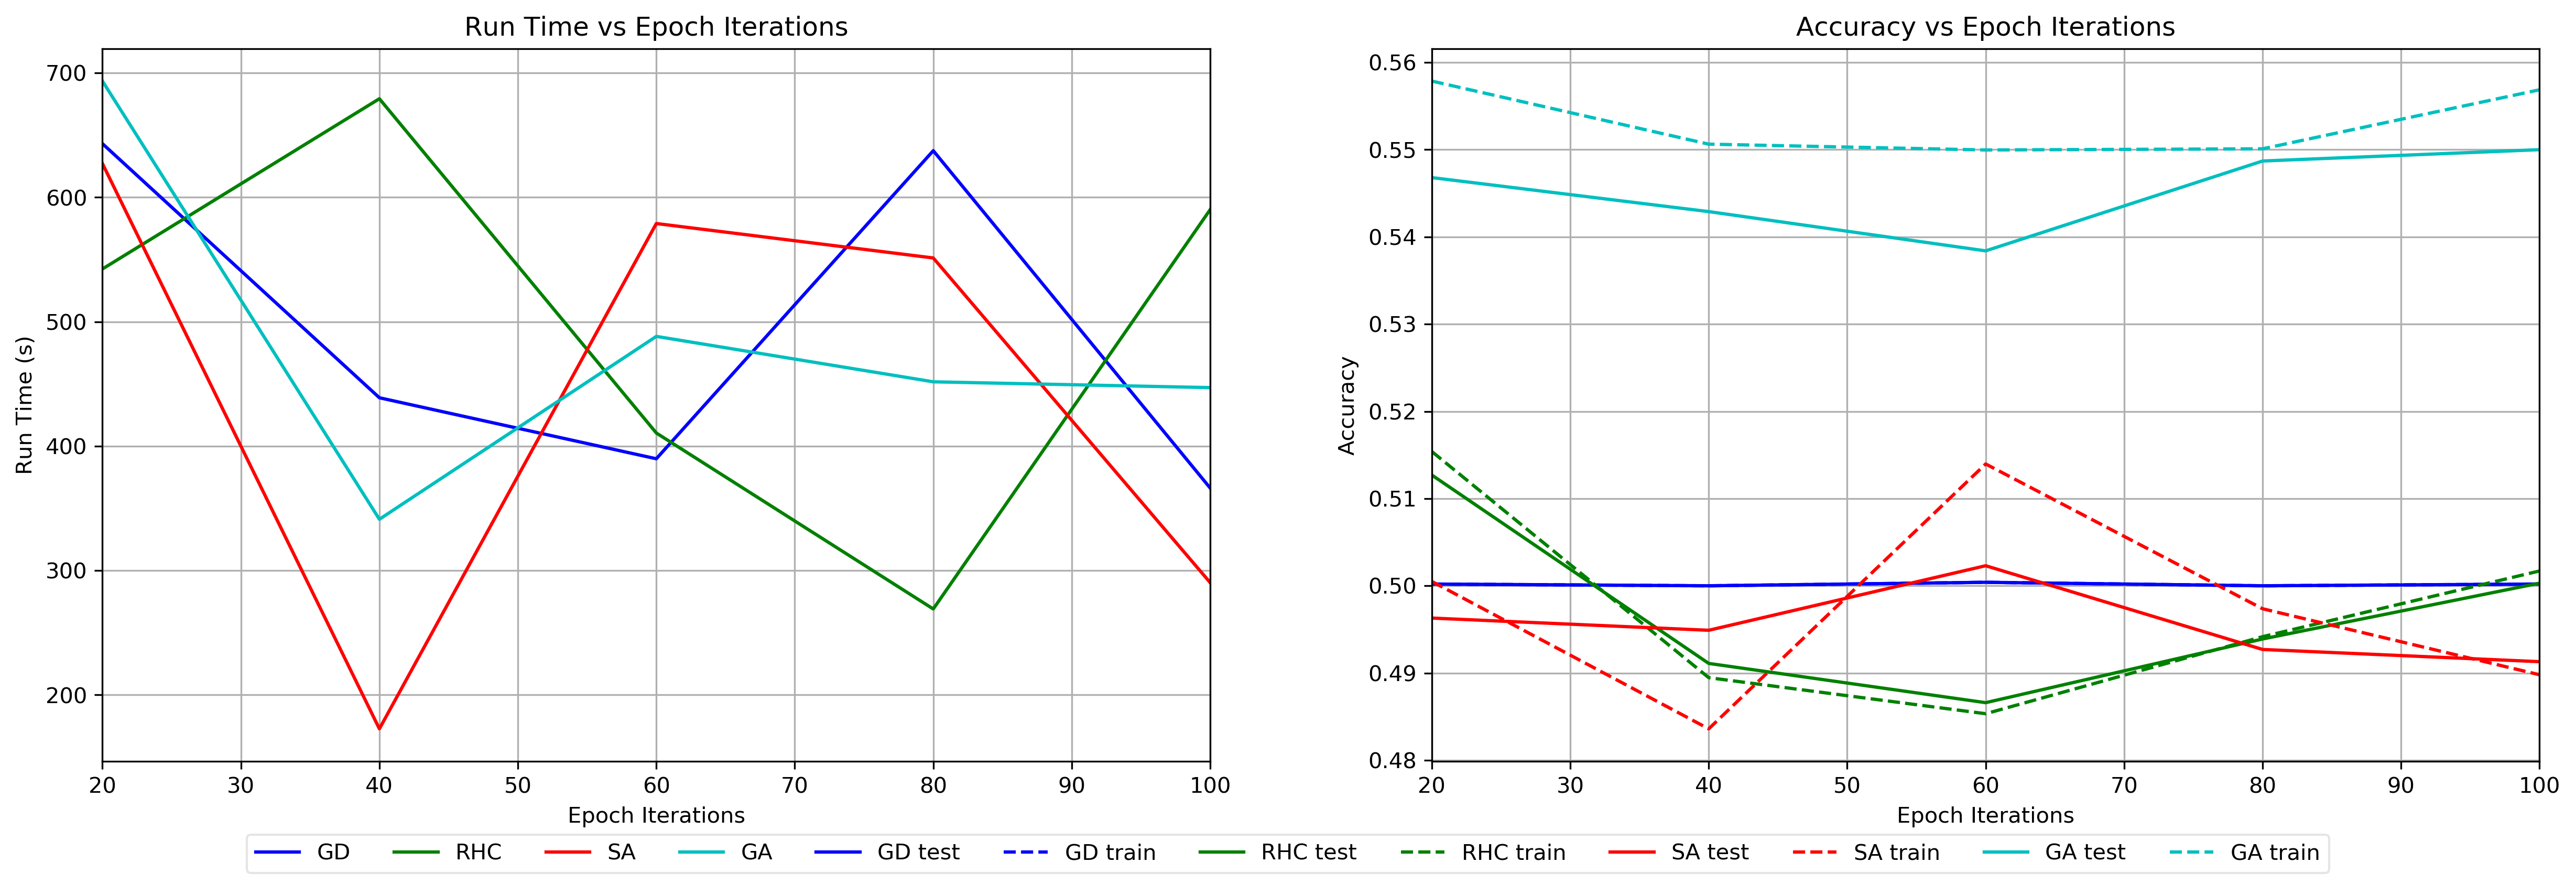

In [134]:
n = len(iteration_range)

fig = plt.figure(figsize=(20, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(iteration_range, time_tr['backprop']['iter'][0:n], label='GD', linestyle='-', color='b')
plt.plot(iteration_range, time_tr['rhc']['iter'][0:n], label='RHC', linestyle='-', color='g')
plt.plot(iteration_range, time_tr['sa']['iter'][0:n], label='SA', linestyle='-', color='r')
plt.plot(iteration_range, time_tr['ga']['iter'][0:n], label='GA', linestyle='-', color='c')

plt.ylabel("Run Time (s)")
plt.xlabel("Epoch Iterations")
plt.title("Run Time vs Epoch Iterations")
plt.xlim(left=iteration_range[0], right=iteration_range[-1])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iteration_range, acc_te['backprop']['iter'][0:n], label='GD test', linestyle='-', color='b')
plt.plot(iteration_range, acc_tr['backprop']['iter'][0:n], label='GD train', linestyle='--', color='b')

plt.plot(iteration_range, acc_te['rhc']['iter'][0:n], label='RHC test', linestyle='-', color='g')
plt.plot(iteration_range, acc_tr['rhc']['iter'][0:n], label='RHC train', linestyle='--', color='g')

plt.plot(iteration_range, acc_te['sa']['iter'][0:n], label='SA test', linestyle='-', color='r')
plt.plot(iteration_range, acc_tr['sa']['iter'][0:n], label='SA train', linestyle='--', color='r')

plt.plot(iteration_range, acc_te['ga']['iter'][0:n], label='GA test', linestyle='-', color='c')
plt.plot(iteration_range, acc_tr['ga']['iter'][0:n], label='GA train', linestyle='--', color='c')

plt.ylabel("Accuracy")
plt.xlabel("Epoch Iterations")
plt.title("Accuracy vs Epoch Iterations")
fig.legend(loc='lower center', ncol=12, framealpha=0.5)
plt.xlim(left=iteration_range[0], right=iteration_range[-1])
plt.grid(True)

plt.savefig("img/randomized-comparison.png")

For sanity check let's compare the deep network.

In [135]:
iteration_range = list( range(20, 120, 20) )

ann = [129, 129*2, 129]

for i in iteration_range:
    algo = 'backprop'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=ann, activation='sigmoid', \
                                     algorithm='gradient_descent', max_iters=i, \
                                     learning_rate=0.06, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter-deep', clf, kf)
    
    algo = 'rhc'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=ann, activation='sigmoid', \
                                     algorithm='random_hill_climb', max_iters=i, \
                                     learning_rate=0.06, restarts=2, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter-deep', clf, kf)
    
    algo = 'sa'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=ann, activation='sigmoid', \
                                     algorithm='simulated_annealing', max_iters=i, \
                                     learning_rate=0.06, schedule=mlrose.GeomDecay(decay=0.9), \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter-deep', clf, kf)
    
    algo = 'ga'
    print(algo, i)
    clf = mlrose.NeuralNetwork(hidden_nodes=ann, activation='sigmoid', \
                                     algorithm='genetic_alg', max_iters=i, \
                                     learning_rate=0.06, pop_size=50, \
                                     early_stopping=True, max_attempts=10)
    evaluate(algo, 'iter-deep', clf, kf)

backprop 20
rhc 20
sa 20
ga 20
backprop 40
rhc 40
sa 40
ga 40
backprop 60
rhc 60
sa 60
ga 60
backprop 80
rhc 80
sa 80
ga 80
backprop 100
rhc 100
sa 100
ga 100


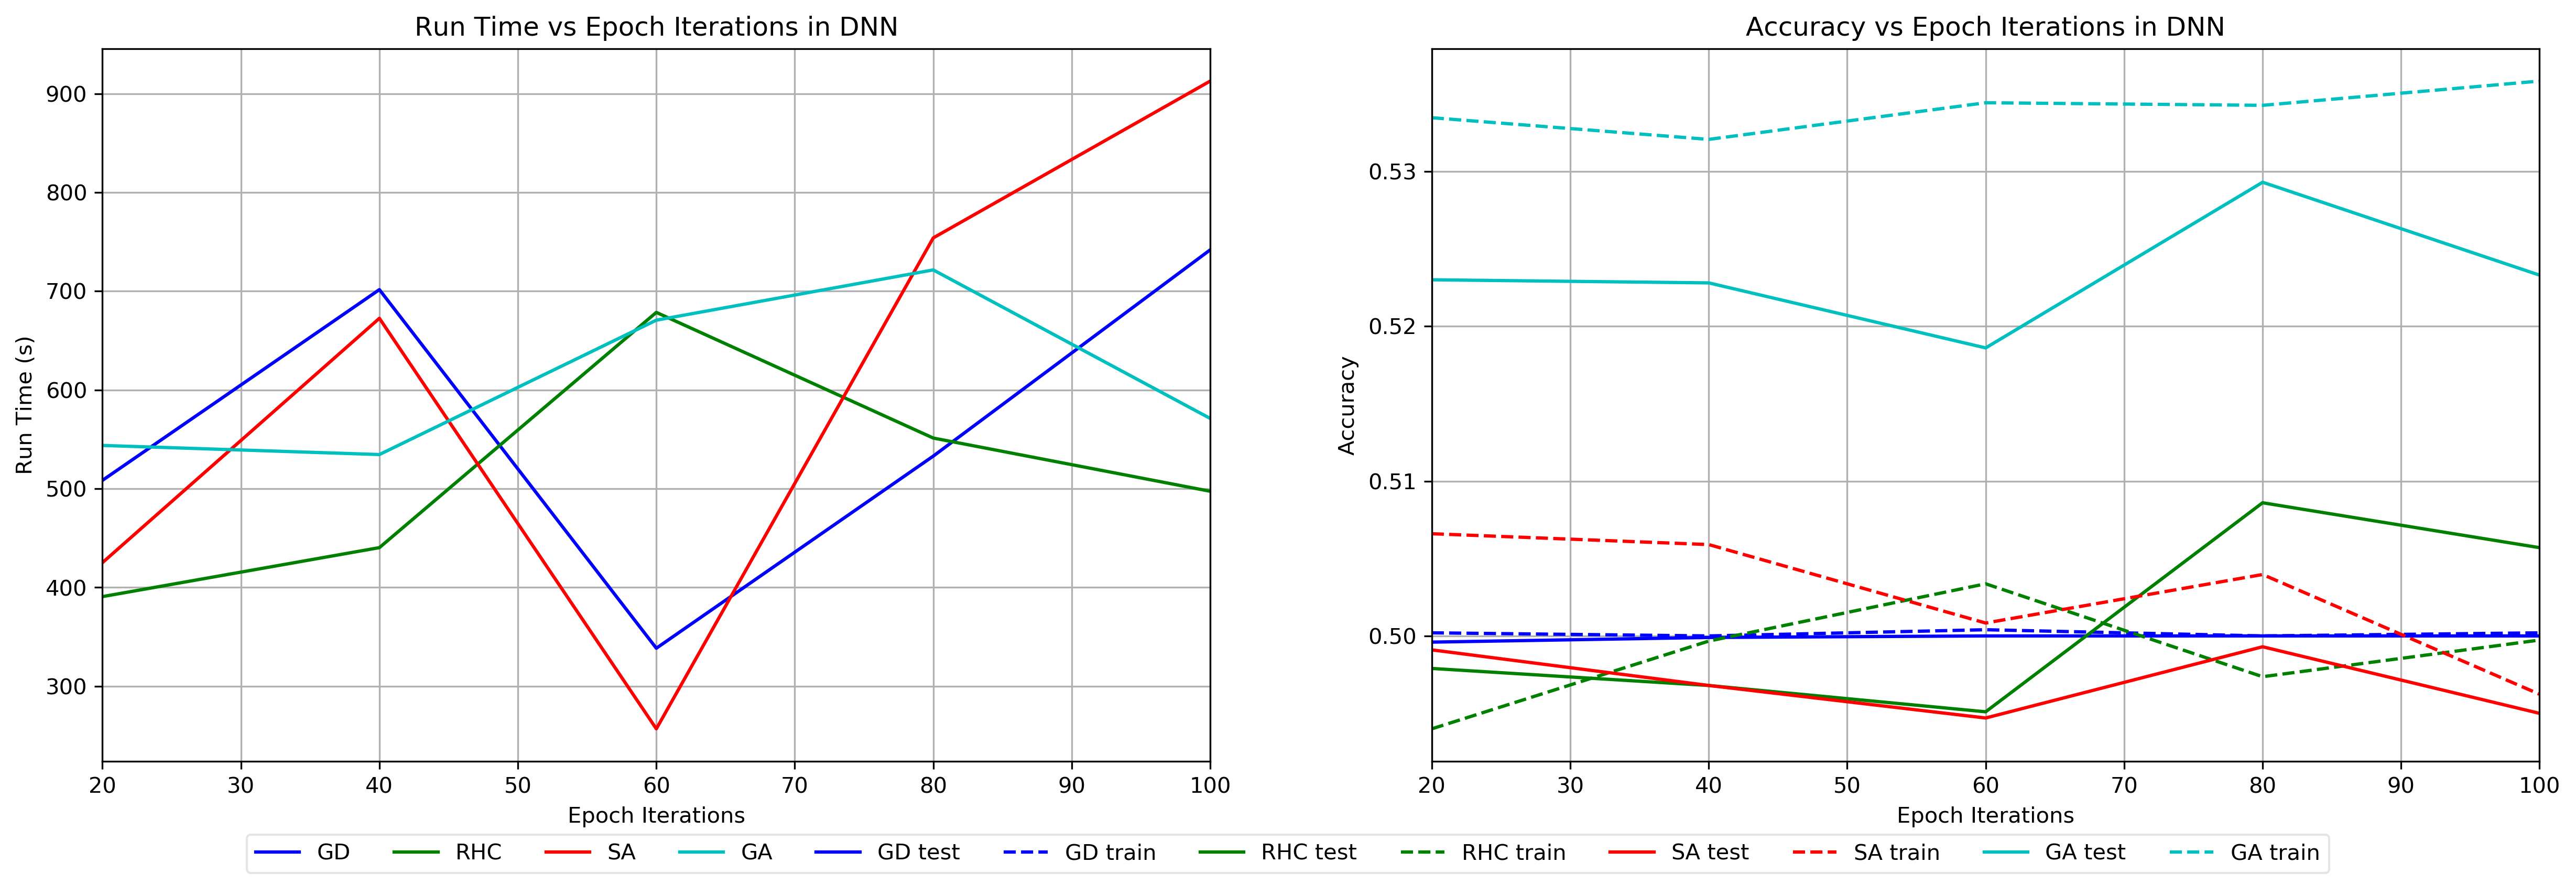

In [136]:
n = len(iteration_range)

fig = plt.figure(figsize=(20, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(iteration_range, time_tr['backprop']['iter-deep'][0:n], label='GD', linestyle='-', color='b')
plt.plot(iteration_range, time_tr['rhc']['iter-deep'][0:n], label='RHC', linestyle='-', color='g')
plt.plot(iteration_range, time_tr['sa']['iter-deep'][0:n], label='SA', linestyle='-', color='r')
plt.plot(iteration_range, time_tr['ga']['iter-deep'][0:n], label='GA', linestyle='-', color='c')

plt.ylabel("Run Time (s)")
plt.xlabel("Epoch Iterations")
plt.title("Run Time vs Epoch Iterations in DNN")
plt.xlim(left=iteration_range[0], right=iteration_range[-1])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iteration_range, acc_te['backprop']['iter-deep'][0:n], label='GD test', linestyle='-', color='b')
plt.plot(iteration_range, acc_tr['backprop']['iter'][0:n], label='GD train', linestyle='--', color='b')

plt.plot(iteration_range, acc_te['rhc']['iter-deep'][0:n], label='RHC test', linestyle='-', color='g')
plt.plot(iteration_range, acc_tr['rhc']['iter-deep'][0:n], label='RHC train', linestyle='--', color='g')

plt.plot(iteration_range, acc_te['sa']['iter-deep'][0:n], label='SA test', linestyle='-', color='r')
plt.plot(iteration_range, acc_tr['sa']['iter-deep'][0:n], label='SA train', linestyle='--', color='r')

plt.plot(iteration_range, acc_te['ga']['iter-deep'][0:n], label='GA test', linestyle='-', color='c')
plt.plot(iteration_range, acc_tr['ga']['iter-deep'][0:n], label='GA train', linestyle='--', color='c')

plt.ylabel("Accuracy")
plt.xlabel("Epoch Iterations")
plt.title("Accuracy vs Epoch Iterations in DNN")
fig.legend(loc='lower center', ncol=12, framealpha=0.5)
plt.xlim(left=iteration_range[0], right=iteration_range[-1])
plt.grid(True)

plt.savefig("img/randomized-comparison-deep.png")